# FinBert Embedding Research

In [1]:
%autosave 30

Autosaving every 30 seconds


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
import torch

In [3]:
def check_memory():
    print('GPU memory: %.1f' % (torch.cuda.memory_allocated() // 1024 ** 2))

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [5]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3).to(device)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

#----------- RUN ABOVE FIRST FOR EVERYTHING TO WORK

In [13]:
sentences = ["there is a shortage of capital, and we need extra financing", 
             "growth is strong and we have plenty of liquidity",
             "growth is strong and we have plenty of liquidity now",
             "growth is weak and we have plenty of liquidity",
             "there are doubts about our finances", 
             "profits are flat"]

In [46]:
inputs = tokenizer(sentences, return_tensors="pt", max_length=64, padding='max_length', truncation=True).to(device)
outputs = finbert(**inputs, output_hidden_states=True)

labels = {0:'neutral', 1:'positive',2:'negative'}
for idx, sent in enumerate(sentences):
    print(sent, '----', labels[np.argmax(outputs[0].cpu().detach().numpy()[idx])])

Dow Jones Futures Rebound After Stock Market Sells Off On China Property Default Fears; These 4 Top Growth Stocks Tumbled ---- negative
Dow Jones Futures Rise After Stock Market Sells Off On China Property Default Fears; These 4 Top Growth Stocks Tumbled ---- negative
With U.S. Credit Default No Longer a Likely Threat, Eyes Turn Back Toward the Fed ---- negative
S&P 500 Claws Back Losses on Easing Fears of U.S. Default By Investing.com ---- negative
Dow Jones Futures Rise Despite China's Evergrande Default Warning After Fed Fuels Market Rally ---- positive
Dow Jones Futures Dive On China Default Fears With Stock Market Rally At Turning Point; What To Do Now ---- neutral
Apple — Highlighting Commitment To 'Diversity' — Says Siri Will No Longer Default To Female Voice ---- neutral
No, Apple Still Won't  Quite Let You Set A Default Music Service in iOS 14.5 ---- neutral
Google Pays Apple $8-12 Bn Every Year To Be Default Search Engine On Apple Devices: Report ---- neutral
DOJ: Google Pays

In [32]:
print(type(outputs))
print(len(outputs.hidden_states)) #total hidden states
print(outputs.hidden_states[-1].shape) #(batch_size, sequence_length, hidden_size)
#sequence_length is longest seq in batch

<class 'transformers.modeling_outputs.SequenceClassifierOutput'>
13
torch.Size([3, 64, 768])


In [36]:
from sklearn.metrics.pairwise import cosine_similarity

def tests(layer):
    x = lambda h_idx, sen: np.hstack(outputs.hidden_states[h_idx][sen].cpu().detach().numpy())
    target = x(layer, 1)  #1st sentence
    a = x(layer, 2) #2nd sentence
    b = x(layer, 3)
    # print(target.shape, a.shape, b.shape)

    print(cosine_similarity([a, b], [target]), '\n')
tests(-1) #layer -1
tests(-2) #layer -2 
tests(-3)
tests(0)
tests(1)

[[0.3754264]
 [0.4140498]] 

[[0.46129707]
 [0.47162113]] 

[[0.47874796]
 [0.48315597]] 

[[0.6744245 ]
 [0.66781634]] 

[[0.6612018]
 [0.6672796]] 



# Abhi's stuff modified 

In [1]:
# duplicates needs dropping (probably based on headline and summary)

## Save news_df as csv (done once)

In [74]:
import sys
import os

import pandas as pd

from database import database

In [8]:
news_doc = []
for doc in database.news_collection.find({}):
    news_doc.append(doc)

In [9]:
news_df = pd.DataFrame(news_doc)
news_df.head()

,_id,datetime,headline,image,source,summary,url,api,counterparty,date,keyword_count,sentiment,category,related,id
0,616a9214d6b0969db79ff380,1634342006,"Dow Jones Futures: Microsoft, Tesla Rival Xpen...",https://s.yimg.com/uu/api/res/1.2/8E9xXtahKzzU...,Yahoo,"With a confirmed market rally, how aggressive ...",https://finnhub.io/api/news?id=0a71ef5127fb093...,Finnhub,TSLA,2021-10-16,{},0.0,NaN,NaN,NaN
1,616a9214d6b0969db79ff381,1634345700,Tesla Will Probably Beat Earnings Estimates. W...,https://s.yimg.com/ny/api/res/1.2/Gc1PiHZWDkam...,Yahoo,Tesla will easily beat earnings expectations ...,https://finnhub.io/api/news?id=b21fa618c07df48...,Finnhub,TSLA,2021-10-16,{},-1.0,NaN,NaN,NaN
2,616a9214d6b0969db79ff382,1634342280,Musk Trolls Bezos Over Wealth. He Could have T...,https://s.yimg.com/ny/api/res/1.2/eLHfCjFR8LCr...,Yahoo,"In a tweet, the Tesla CEO drew attention to hi...",https://finnhub.io/api/news?id=e94ea5b855e79f8...,Finnhub,TSLA,2021-10-16,{},-1.0,NaN,NaN,NaN
3,616a9214d6b0969db79ff383,1634335078,'Big Short' investor Burry says he's no longer...,https://s.yimg.com/uu/api/res/1.2/BnJkedCmxSup...,Yahoo,Burry's Scion Asset Management said in a regul...,https://finnhub.io/api/news?id=d162aec79de9fdb...,Finnhub,TSLA,2021-10-16,{},1.0,NaN,NaN,NaN
4,616a9214d6b0969db79ff385,1634334249,Into the Heart of Q3 Earnings Season,https://s.yimg.com/uu/api/res/1.2/Dbt0ApA69Vv9...,Yahoo,The big banks got us off to a flying start in ...,https://finnhub.io/api/news?id=f453ec3b3fffc3e...,Finnhub,TSLA,2021-10-16,{},1.0,NaN,NaN,NaN


In [10]:
news_df.to_csv('./news_df.csv')

## Batch inf embeddings for all articles

In [75]:
import pandas as pd

news_df = pd.read_csv('./news_df.csv')
headlines = list(news_df.headline.fillna('NaN'))
headlines

In [7]:
def batch_inf(sentences):
    inputs = tokenizer(sentences, return_tensors="pt", max_length=64, padding='max_length', truncation=True).to(device)
    outputs = finbert(**inputs, output_hidden_states=True)
    
    ret = outputs.hidden_states[-1].cpu().detach().numpy() #last layer hidden (batch, seq_len, emb_dim)
    return ret.reshape(ret.shape[0], ret.shape[1]*ret.shape[2]) #flatten to 1-d

In [8]:
#save all embeddings as np array files
from tqdm import tqdm
print('start')
embeds = []
batch_size = 64
for i in tqdm(range(0, len(headlines), batch_size)):
    batch = headlines[i:i+batch_size]
    ret = batch_inf(batch)

    temp = np.array((batch + [''], ret))
    with open(f'./saved_arrays/{i}.npy', 'wb') as f:
        np.save(f, temp)


  0%|                                                                     | 0/3955 [00:00<?, ?it/s]

start


100%|██████████████████████████████████████████████████████████| 3955/3955 [10:45<00:00,  6.12it/s]


In [39]:
torch.cuda.empty_cache()
check_memory()

GPU memory: 418.0


## Find articles similar to keywords

In [103]:
keywords = ["Ownership change", "Change of control", "Acceleration", "accelerate", "default", "Insolvency", "Insolvent", "Delay", "Late", "Failure", "fail", "Dispute", "Liquidation", "Liquidator", "Margin call", "Haircut", "Bank run", "Termination", "Moratorium", "Suspension", "Suspend", "Fraud", "misrepresentation", "Fine", "sanction", "Breach", "Reschedule", "Restructuring", "Restructure", "Credit event", "Losses", "Loss", "Bailout", "Bailin", "Bankrupt", "Receivership", "Receiver", "Judicial Management", "Judicial Manager", "Administration", "Administrator", "Sequestrate", "Sequestration", "Support", "Capital call", "Liquidity event", "Negative trends", "Price changes", "Board infighting", "Corruption", "Inappropriate or ultra vires dealings", "Negative working capital", "Acquisition", "LBO", "Qualified audit opinion", "Regulatory breach", "Non-performing assets", "Provisions", "Force majeur", "Distress", "Frozen", "Delisted", "Sued", "Suit", "Arrested", "Disappeared", "Uncontactable"]

def keyword_count(news):
    keywords_count_dict = {}
    
    for keyword in keywords:
        for news_str in news:
            news_str = news_str.lower().split()
            for word in news_str:
                if keyword == word:
                    keywords_count_dict[keyword] = keywords_count_dict.get(keyword, 0) + 1
    
    return keywords_count_dict

def keyword_ret(news, keyword):
    matched_titles = []
    
    for news_str in news:
        for word in news_str.lower().split():
            if keyword == word:
                matched_titles.append(news_str)
    
    return matched_titles

def plot_keyword_frequency (news_keyword_frequency):
    news_list = news_keyword_frequency.items()
    print(news_list)
#     news_list = sorted(news_list) 
    x, y = zip(*news_list)

    plt.rcParams["figure.figsize"] = (20,3)
    plt.plot(x, y)
    plt.xticks(rotation='vertical')
    plt.show()
    
def keyword_wordcloud (text_string):
    wordcloud = WordCloud().generate(text_string)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [111]:
sued_list = keyword_ret(news_df.headline.fillna('NaN'), 'sued')
defaulted_list = keyword_ret(news_df.headline.fillna('NaN'), 'default')

In [126]:
target_list = sued_list
print(len(target_list))
target_list

79


['Tesla Sued Rivian Over Batteries, EV Trade Secrets. It’s Not a Big Deal, Yet.',
 'Tesla sued over crash that injured Houston-area police officers',
 "Tesla-Built 'Big Battery' Allegedly Failed To Provide Essential Services in Australia — Operator Gets Sued By Energy Regulator",
 'Apple, Google Sued By Jawbone Over Patent Violations In Noise-Canceling Technology: Report',
 'Apple Sued Over Allegedly Concealing Defect That Causes M1 MacBook Screens To Crack',
 'Google\xa0to Be Sued by States Over Alleged Play Store Abuse',
 'Google sued by states alleging Play Store fees violate antitrust law',
 'AAPL Stock Slightly Up, Apple Sued for Failing to Remove Telegram from App Store',
 'Apple Sued Over Not Taking Down Telegram After Capitol Hill Riot',
 'Apple sued by group insisting it curb Telegram after Capitol attack',
 'Apple sued by rival over alleged App Store monopoly - TechCentral',
 'Apple is sued by rival over alleged App Store monopoly',
 'Apple is sued by rival over alleged App S

In [129]:
target_embs = batch_inf(target_list)
target_centroid = np.mean(target_embs, axis=0)

In [131]:
import os
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def get_sim_articles(target_centroid):
    results = []
    folder = './saved_arrays/'
    min_score = 0.65
    for file_name in tqdm(os.listdir(folder)):
        array = np.load(os.path.join(folder, file_name), allow_pickle=True)

        scores = cosine_similarity(array[1], [target_centroid])

        matched_headlines = np.array(array[0])[np.where(scores > min_score)[0]].reshape(-1)
        matched_scores = scores[np.where(scores > min_score)[0]].reshape(-1)

        for i in zip(matched_headlines, matched_scores):
            results.append(i)
            
    return results

results = get_sim_articles(target_centroid)

100%|██████████████████████████████████████████████████████████| 3955/3955 [10:32<00:00,  6.25it/s]


In [136]:
def gen_result_csv(keyword):
    results_df = pd.DataFrame(results).sort_values([1], ascending=False)

    results_df['contains keyword'] = results_df.apply(lambda row: keyword in row[0].lower(), axis = 1)
    results_df.to_csv(f'./sim_{keyword}.csv')
    
gen_result_csv('sued')

### Other Experiments

In [44]:
target = batch_inf(["Dow Jones Futures Rebound After Stock Market Sells Off On China Property Default Fears; These 4 Top Growth Stocks Tumbled"])

In [46]:
from sklearn.metrics.pairwise import cosine_similarity

sentences = defaulted_list

embed = batch_inf(defaulted_list)

# x = lambda h_idx, sen: np.hstack(outputs.hidden_states[h_idx][sen].cpu().detach().numpy())

# layer = -1

source = []
for i, sen in enumerate(sentences):
    source.append(embed[i])

target = [default_centroid]#[x(layer, 6)]
scores = cosine_similarity(source, target)

temp = pd.DataFrame(zip(sentences, scores))
temp.to_csv('./temp2.csv')
temp

,0,1
0,Dow Jones Futures Rebound After Stock Market S...,[0.71440923]
1,Dow Jones Futures Rise After Stock Market Sell...,[0.7163255]
2,With U.S. Credit Default No Longer a Likely Th...,[0.58092976]
3,S&P 500 Claws Back Losses on Easing Fears of U...,[0.7006258]
4,Dow Jones Futures Rise Despite China's Evergra...,[0.6940906]
5,Dow Jones Futures Dive On China Default Fears ...,[0.65235835]
6,Apple — Highlighting Commitment To 'Diversity'...,[0.54011375]
7,"No, Apple Still Won't Quite Let You Set A Def...",[0.5193939]
8,Google Pays Apple $8-12 Bn Every Year To Be De...,[0.51391816]
9,DOJ: Google Pays up to $12B Just to Be the De...,[0.56565404]


## Abhi's other code

In [12]:
headline_keyword_frequency = keyword_count(news_df.headline.fillna('NaN'))
plot_keyword_frequency(headline_keyword_frequency)

dict_items([('Acceleration', 12), ('accelerate', 57), ('Default', 48), ('Insolvency', 1), ('Delay', 107), ('Late', 339), ('Failure', 27), ('fail', 28), ('Dispute', 35), ('Liquidation', 1), ('Haircut', 1), ('Termination', 10), ('Suspension', 33), ('Suspend', 17), ('Fraud', 72), ('misrepresentation', 1), ('Fine', 117), ('sanction', 2), ('Breach', 39), ('Restructuring', 20), ('Restructure', 3), ('Losses', 406), ('Loss', 172), ('Bailout', 4), ('Bankrupt', 2), ('Receiver', 4), ('Administration', 92), ('Administrator', 1), ('Support', 385), ('Corruption', 3), ('Acquisition', 570), ('LBO', 3), ('Provisions', 3), ('Distress', 2), ('Frozen', 5), ('Delisted', 6), ('Sued', 45), ('Suit', 38), ('Arrested', 3)])


NameError: name 'plt' is not defined

In [11]:
summary_keyword_frequency = keyword_count(news_df.summary)
plot_keyword_frequency(summary_keyword_frequency)

AttributeError: 'float' object has no attribute 'split'

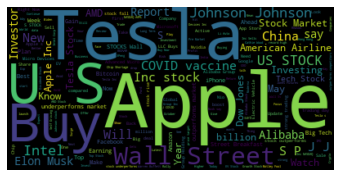

In [8]:
headline_text = " ".join(headline for headline in news_df.headline)
keyword_wordcloud(headline_text)

In [9]:
def counterparty_keyword_count (news_counterparty, target_counterparty: str):
    keywords_count_dict = {}
    
    target_news_headline = news_counterparty.loc[news_counterparty["counterparty"]==target_counterparty, "headline"]
    target_news_summary = news_counterparty.loc[news_counterparty["counterparty"]==target_counterparty, "summary"]


    for keyword in keywords:
        for news_str in target_news_summary:
            news_str = news_str.split()
            for word in news_str:
                if keyword == word:
                    keywords_count_dict[keyword] = keywords_count_dict.get(keyword, 0) + 1
    
    return keywords_count_dict

dict_items([('accelerate', 30), ('Delay', 2), ('Late', 3), ('Failure', 1), ('fail', 6), ('Fine', 2), ('Losses', 1), ('Loss', 6), ('Administration', 93), ('Administrator', 1), ('Acquisition', 37), ('Sued', 6)])


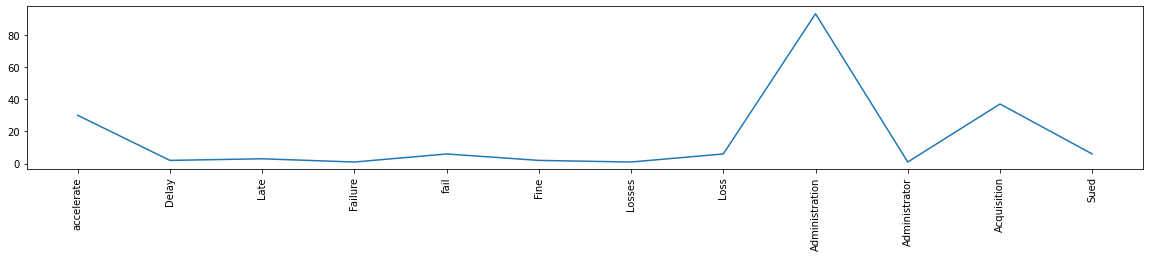

In [10]:
# graph for TSLA
plot_keyword_frequency(counterparty_keyword_count (news_df, 'TSLA'))

In [11]:
def counterparty_keyword_date_occurance (news_counterparty, target_counterparty: str, target_keyword: str):
    keywords_count_dict = {}
    keyword_count = 0
    
    target_news = news_counterparty.loc[news_counterparty["counterparty"]==target_counterparty]
    target_news = target_news[target_news['summary'].str.contains(target_keyword)]
    
    '''
    select a keyword
    check its frequency as we move along the x-axis
    see when what keyword appears
    connect with the frontend to make it interactive
    '''
#     print(target_news)
    for date in target_news['date']:
        keywords_count_dict[date] = keywords_count_dict.get(date, 0) + 1
        
    return keywords_count_dict

dict_items([(nan, 46), ('2021-10-13', 1), ('2021-10-09', 3), ('2021-10-08', 1), ('2021-09-21', 1), ('2021-08-31', 1), ('2021-08-30', 1), ('2021-08-11', 1), ('2020-12-04', 1), ('2020-11-20', 1), ('2020-11-18', 2), ('2020-11-06', 1), ('2020-10-22', 1)])


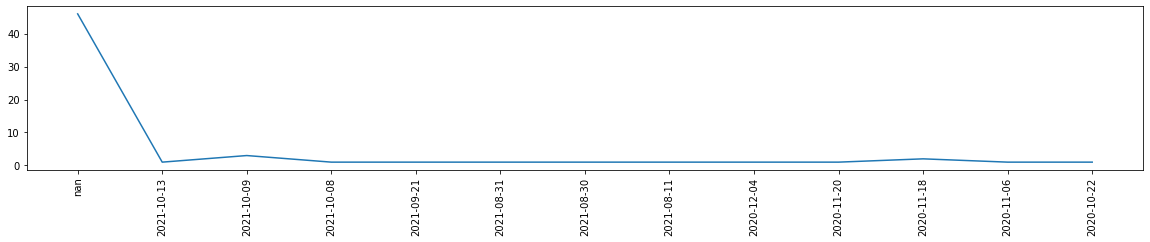

In [12]:
plot_keyword_frequency(counterparty_keyword_date_occurance (news_df, 'TSLA', 'accelerate'))

In [17]:

# Read data into papers
papers = news_df
# Print head
papers.head()

,_id,datetime,headline,image,source,summary,url,api,counterparty,sentiment,date
0,616a9214d6b0969db79ff380,1634342006,"Dow Jones Futures: Microsoft, Tesla Rival Xpen...",https://s.yimg.com/uu/api/res/1.2/8E9xXtahKzzU...,Yahoo,"With a confirmed market rally, how aggressive ...",https://finnhub.io/api/news?id=0a71ef5127fb093...,Finnhub,TSLA,NaN,NaN
1,616a9214d6b0969db79ff381,1634345700,Tesla Will Probably Beat Earnings Estimates. W...,https://s.yimg.com/ny/api/res/1.2/Gc1PiHZWDkam...,Yahoo,Tesla will easily beat earnings expectations ...,https://finnhub.io/api/news?id=b21fa618c07df48...,Finnhub,TSLA,NaN,NaN
2,616a9214d6b0969db79ff382,1634342280,Musk Trolls Bezos Over Wealth. He Could have T...,https://s.yimg.com/ny/api/res/1.2/eLHfCjFR8LCr...,Yahoo,"In a tweet, the Tesla CEO drew attention to hi...",https://finnhub.io/api/news?id=e94ea5b855e79f8...,Finnhub,TSLA,NaN,NaN
3,616a9214d6b0969db79ff383,1634335078,'Big Short' investor Burry says he's no longer...,https://s.yimg.com/uu/api/res/1.2/BnJkedCmxSup...,Yahoo,Burry's Scion Asset Management said in a regul...,https://finnhub.io/api/news?id=d162aec79de9fdb...,Finnhub,TSLA,NaN,NaN
4,616a9214d6b0969db79ff384,1634335078,'Big Short' investor Burry says he's no longer...,https://static.reuters.com/resources/r/?m=02&d...,Reuters,"Investor Michael Burry of ""The Big Short"" fame...",https://finnhub.io/api/news?id=73b71d9c99019a1...,Finnhub,TSLA,0.0,2021-10-16


In [18]:
papers = papers.drop(columns=['_id', 'url', 'image', 'source', 'api'], axis=1).sample(100)
# Print out the first rows of papers
papers.head()

,datetime,headline,summary,counterparty,sentiment,date
18978,1624425600,"Apple CEO warns congress, claims antitrust bil...","Apple CEO warns congress, claims antitrust bil...",AAPL,NaN,NaN
58780,1638454560,January 2022 Options Now Available For Apple,Investors in Apple Inc (Symbol: AAPL) saw new ...,AAPL,NaN,NaN
58876,1638435682,Johnson & Johnson : U.S. FDA Approves DARZALEX...,News ReleaseMedia Contacts:Christie CorbettOff...,JNJ,NaN,NaN
23766,1611069212,Free Apple TV+ Promo Extended to July - Thurro...,Apple has quietly extended its free Apple TV+ ...,AAPL,NaN,NaN
55010,1617908640,NIO and Other Chinese EV Stocks Are Struggling...,A huge gap has opened up between analysts' pri...,XPEV,NaN,NaN


In [20]:
# Load the regular expression library
import re
# Remove punctuation
papers['headline'] = \
papers['summary'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['headline'] = \
papers['headline'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['headline'].head()

18978    apple ceo warns congress claims antitrust bill...
58780    investors in apple inc (symbol: aapl) saw new ...
58876    news releasemedia contacts:christie corbettoff...
23766    apple has quietly extended its free apple tv+ ...
55010    a huge gap has opened up between analysts' pri...
Name: headline, dtype: object

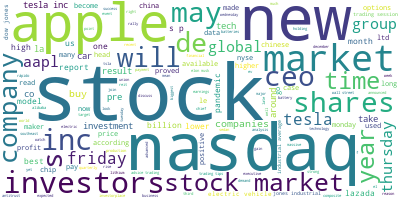

In [21]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(papers['headline'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [25]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = papers.headline.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['apple', 'ceo', 'warns', 'congress', 'claims', 'antitrust', 'bills', 'rushed', 'ny', 'times', 'reports', 'aapl', 'amzn', 'fb', 'goog', 'googl']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/poswalabhishek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]


In [27]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"group" + 0.010*"lazada" + 0.010*"apple" + 0.009*"us" + '
  '0.009*"stocks" + 0.009*"rapido" + 0.009*"watch" + 0.009*"automotive" + '
  '0.007*"chinese" + 0.007*"billion"'),
 (1,
  '0.015*"tesla" + 0.015*"lithium" + 0.011*"investors" + 0.010*"tsla" + '
  '0.010*"nasdaq" + 0.010*"batteries" + 0.009*"group" + 0.007*"co" + '
  '0.007*"vehicles" + 0.007*"lazada"'),
 (2,
  '0.012*"de" + 0.010*"company" + 0.009*"market" + 0.009*"stock" + '
  '0.009*"apple" + 0.007*"stocks" + 0.007*"la" + 0.007*"inc" + 0.007*"trading" '
  '+ 0.006*"quarterly"'),
 (3,
  '0.011*"nasdaq" + 0.009*"take" + 0.008*"workers" + 0.008*"growing" + '
  '0.008*"electric" + 0.008*"much" + 0.008*"past" + 0.008*"ford" + '
  '0.008*"head" + 0.007*"stocks"'),
 (4,
  '0.020*"de" + 0.012*"la" + 0.012*"tesla" + 0.012*"options" + '
  '0.009*"available" + 0.008*"el" + 0.008*"produccion" + 0.008*"aapl" + '
  '0.008*"new" + 0.008*"january"'),
 (5,
  '0.017*"inc" + 0.017*"apple" + 0.012*"nasdaq" + 0.009*"shares" + '
  '0

In [32]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/poswalabhishek/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/poswalabhishek/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/poswalabhishek/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/poswalabhishek/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/poswalabhishek/opt/anaconda3/lib/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.117195 -0.069575       1        1  17.150178
0     -0.140346 -0.068060       2        1  15.656475
2      0.040582 -0.057191       3        1  13.258333
7      0.027102  0.136520       4        1  12.861029
5      0.034696 -0.009507       5        1  10.736788
9      0.065597 -0.043749       6        1   8.038648
4     -0.087816 -0.008466       7        1   6.884979
3      0.010602  0.074640       8        1   6.139619
6     -0.024517  0.045412       9        1   5.320142
1     -0.043095 -0.000023      10        1   3.953809, topic_info=           Term       Freq      Total Category  logprob  loglift
450          de   6.000000   6.000000  Default  30.0000  30.0000
508       tesla   8.000000   8.000000  Default  29.0000  29.0000
96       nasdaq  12.000000  12.000000  Default  28.0000  28.0000
278       group   5.000000   5.000000  Default  27.0000  27.0000
931      lazada   3.000000   3.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
104  technology   0.376264   2.390966  Topic10  -5.2688   1.3813
409        musk   0.376262   2.404057  Topic10  -5.2688   1.3759
105    thursday   0.376261   5.082670  Topic10  -5.2688   0.6272
124        high   0.376255   3.026794  Topic10  -5.2689   1.1455
506       since   0.376254   2.545350  Topic10  -5.2689   1.3187

[558 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         4  0.211013       aapl
0         5  0.211013       aapl
0         7  0.211013       aapl
0         8  0.211013       aapl
283       1  0.326824  according
...     ...       ...        ...
273       3  0.385515        yet
273       4  0.385515        yet
273       6  0.385515        yet
108       4  0.755900     yields
715       6  0.841594   zackscom

[651 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 3, 8, 6, 10, 5, 4, 7, 2])